In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

### GSV images

#### load, resize and save as np array

ignore steps in this session if the array has already been extracted. 

In [3]:
from PIL import Image

def load_and_resize(image_loc, current_model):
  '''
  load masked_img and masked_2channel into array and resize them. 
  '''
  #current_model = [512, 512, 3]
  test_data = []
  test_gt = []
  with open(image_loc, 'r') as training:
      content = training.readlines()
  for line in content:
      paths = line.split()
      if len(paths) == 2:
          test_data.append(paths[0])
          test_gt.append(paths[1].replace("\n", ""))
      if len(paths) == 3:
          test_data.append(paths[0] + " "+paths[1])
          test_gt.append(paths[2].replace("\n", ""))
      if len(paths) == 1:
          test_data.append(paths[0])
  imgdata = []
  for path1 in test_data:
      imgdata.append(np.asarray((Image.open(path1).resize(current_model[0:2]))))
  labeldata = []
  for path in test_gt:
      labeldata.append(np.asarray((Image.open(path).resize(current_model[0:2]))))

  # convert list of arrays to arrays
  imgdata_array = np.zeros(
      [len(imgdata), current_model[0], current_model[1], current_model[2]], dtype=np.uint8)
  labeldata_array = np.zeros([len(imgdata), current_model[0], current_model[1]], dtype=np.uint8)
  for i in range(len(imgdata)):
      imgdata_array[i, :, :, :] = imgdata[i]
      labeldata_array[i, :, :] = labeldata[i]
  del (imgdata, labeldata)
  return (imgdata_array, labeldata_array)

In [4]:
current_model = [224, 224, 3]
X_train, y_train = load_and_resize(
    "/content/drive/MyDrive/XJ-Project2/labelled_pair_train.txt", current_model)
X_valid, y_valid = load_and_resize(
    "/content/drive/MyDrive/XJ-Project2/labelled_pair_val.txt",current_model)
X_test, y_test = load_and_resize(
    "/content/drive/MyDrive/XJ-Project2/labelled_pair_test.txt", current_model)

In [8]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 224, 224, 3) (280, 224, 224)
(80, 224, 224, 3) (80, 224, 224)
(80, 224, 224, 3) (80, 224, 224)


In [4]:
# this cell can only run once
y_train[y_train < 100] = 0
y_train[y_train >= 100] = 1
y_train_GVI = np.mean(y_train, axis=(1,2))
y_train_GVI[0]

y_valid[y_valid < 100] = 0
y_valid[y_valid >= 100] = 1
y_valid_GVI = np.mean(y_valid, axis=(1,2))

y_test[y_test < 100] = 0
y_test[y_test >= 100] = 1
y_test_GVI = np.mean(y_test, axis=(1,2))

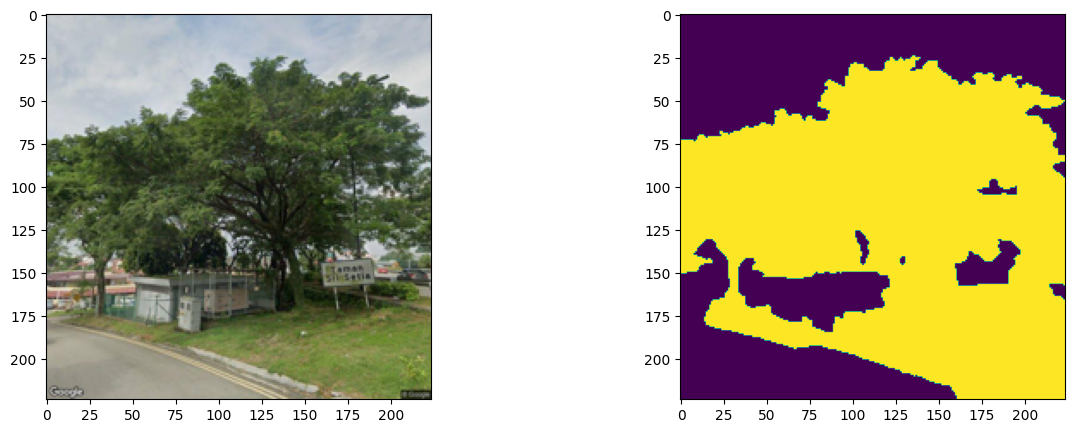

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].imshow(X_test[0])
ax[1].imshow(y_test[0])

In [14]:
import os
import pandas as pd

# extract metadata from file name
def save_file_path_in_list(path):
  data = []
  gt = []
  with open(path, 'r') as f:
      content = f.readlines()
  for line in content:
      paths = line.split()
      if len(paths) == 2:
        data.append(paths[0])
        gt.append(paths[1].replace("\n", ""))

  return data, gt

def retrieve_metadata(path):
  
  _, gt = save_file_path_in_list(path)
  
  label_metadata = []
  for file_name in gt:
    # Retrieve the file name
    file_name = os.path.basename(file_name)

    # Remove the file extension
    file_name = os.path.splitext(file_name)[0]
    # Split the file name into its components using the '-' separator
    file_components = file_name.split('-')
    # Extract the latitude, longitude, and heading information from the file name
    lat = (file_components[0])
    lng = (file_components[1])
    heading = int(file_components[2].split('.')[0])

    label_metadata.append([lat, lng, heading])

  return pd.DataFrame(label_metadata, columns=['lat','lng','heading'])

test_metadata = retrieve_metadata('/content/drive/MyDrive/XJ-Project2/labelled_pair_test.txt')

In [ ]:
test_metadata.head(3)

,lat,lng,heading
0,1.469080304434778,103.7693180467225,60
1,1.469104171408458,103.7625577149652,120
2,1.469124396681811,103.7624672753895,180


# load and train DeepLabv3+ model


In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
from tensorflow.keras import metrics
import tensorflow as tf
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):    # this method can only be named `build`, cannot be changed
        DLV3_model = tf.keras.models.load_model("/content/drive/MyDrive/XJ-Project2/DLV3_model_cityscape_pretrain")
        # Freeze all layers except for the last 5
        for layer in DLV3_model.layers[:-6]:
            layer.trainable = False

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        DLV3_model.compile(loss='binary_crossentropy', 
                           optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                           metrics=[metrics.MeanAbsoluteError()])

        return DLV3_model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=32,   #model crashes with batch size of 32. 
            **kwargs,
        )

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_mean_absolute_error',
    max_trials=3,
    executions_per_trial=1,
    project_name='my_project'
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                min_delta=0.0001,
                patience=10,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True)

#tuner.search(X_train, y_train_GVI, epochs=50, validation_data=(X_valid, y_valid_GVI), callbacks=[early_stopping])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=2)
#best_hps

In [ ]:
#print(best_hps[0].get('batch_size'), best_hps[0].get('learning_rate'))

# final model training

In [ ]:
from tensorflow.keras import metrics
import tensorflow as tf

def build_DLV3_model():    # this method can only be named `build`, cannot be changed
  DLV3_model = tf.keras.models.load_model("/content/drive/MyDrive/XJ-Project2/DLV3_model_cityscape_pretrain.hdf5")
  # Freeze all layers except for the last 5
  for layer in DLV3_model.layers[:-6]:
      layer.trainable = False

  hp_learning_rate = 0.001

  DLV3_model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                      metrics=[metrics.MeanAbsoluteError()])

  return DLV3_model

early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                min_delta=0.0001,
                patience=10,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True)

import time
st =  time.time()

DLV3_model_ = build_DLV3_model()
history = DLV3_model_.fit( X_train, y_train_GVI, epochs=100, batch_size=32,
                                  validation_data=(X_valid, y_valid_GVI), 
                                  callbacks=[early_stopping])

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

Epoch 1/100
9/9 [==============================] - 18s 459ms/step - loss: 0.5014 - mean_absolute_error: 0.1029 - val_loss: 0.4778 - val_mean_absolute_error: 0.0816
Epoch 2/100
9/9 [==============================] - 1s 78ms/step - loss: 0.4777 - mean_absolute_error: 0.0767 - val_loss: 0.4656 - val_mean_absolute_error: 0.0732
Epoch 3/100
9/9 [==============================] - 1s 66ms/step - loss: 0.4756 - mean_absolute_error: 0.0721 - val_loss: 0.4670 - val_mean_absolute_error: 0.0744
Epoch 4/100
9/9 [==============================] - 1s 67ms/step - loss: 0.4748 - mean_absolute_error: 0.0722 - val_loss: 0.4681 - val_mean_absolute_error: 0.0744
Epoch 5/100
9/9 [==============================] - 1s 78ms/step - loss: 0.4751 - mean_absolute_error: 0.0727 - val_loss: 0.4654 - val_mean_absolute_error: 0.0723
Epoch 6/100
9/9 [==============================] - 1s 67ms/step - loss: 0.4751 - mean_absolute_error: 0.0732 - val_loss: 0.4675 - val_mean_absolute_error: 0.0740
Epoch 7/100
9/9 [=========

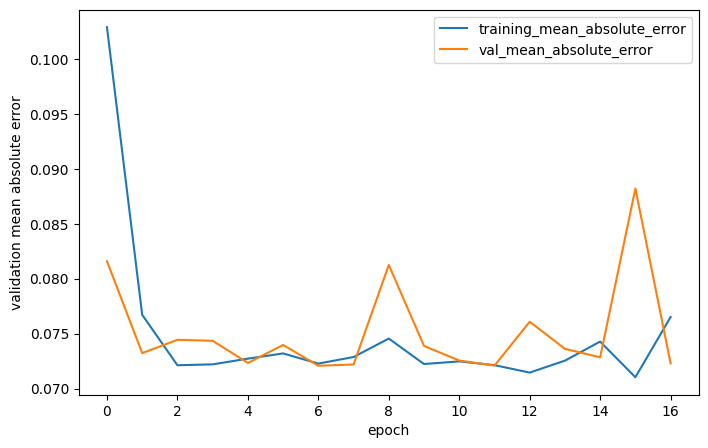

In [ ]:
# for image size 224
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(history.history['mean_absolute_error'])
ax.plot(history.history['val_mean_absolute_error'])

plt.legend(["training_mean_absolute_error", "val_mean_absolute_error"], loc ="upper right")
plt.xlabel('epoch')
plt.ylabel('validation mean absolute error')

plt.show()

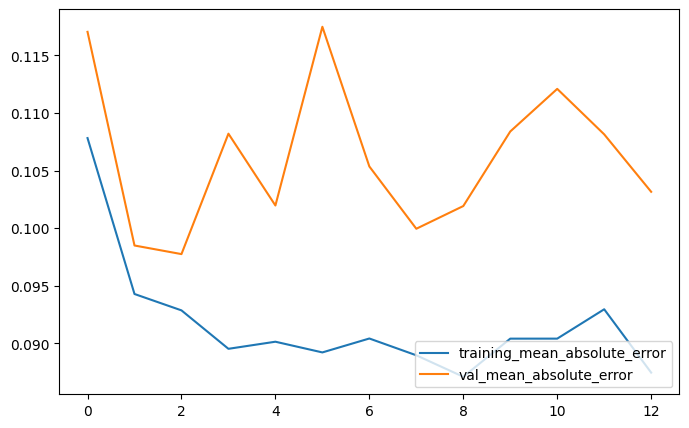

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(history.history['mean_absolute_error'])
ax.plot(history.history['val_mean_absolute_error'])

plt.legend(["training_mean_absolute_error", "val_mean_absolute_error"], loc ="upper right")

plt.show()

In [ ]:
DLV3_model_.save("/content/drive/MyDrive/XJ-Project2/DLV3_model_224_2.hdf5")

# Inference

In [9]:
model = tf.keras.models.load_model('/content/drive/MyDrive/XJ-Project2/DLV3_model.hdf5')

In [10]:
import time
st =  time.time()

pred_ts = model.predict(X_test, batch_size=8)
pred_ts.shape

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

10/10 [==============================] - 1s 10ms/step
training time =  1.5306737422943115 seconds


In [11]:
# compute difference between prediction and true GVI
diff = np.zeros([len(X_test), 1])
for i in range(len(X_test)):
    diff[i] = y_test_GVI[i]-pred_ts[i]

# evaluate accuracy of model
print("Average Absolute GVI error is: %f" % np.mean(np.abs(diff)))
percentile_result = np.percentile(diff, [5, 95])
print("5-95 percentile of Absolute GVI error is (%f, %f)" %
      (percentile_result[0], percentile_result[1]))
print("Correlation of predicted and true GVI is: %f" %
      np.corrcoef(pred_ts.T, y_test_GVI.T)[0, 1])

Average Absolute GVI error is: 0.059194
5-95 percentile of Absolute GVI error is (-0.156107, 0.148028)
Correlation of predicted and true GVI is: 0.928328


In [15]:
import pandas as pd
DLV3_prediction = pd.concat([test_metadata, pd.Series(pred_ts.flatten()), pd.Series(y_test_GVI)], 
                            axis=1)
DLV3_prediction = DLV3_prediction.rename(columns={0: 'pred', 1: 'gt'})
DLV3_prediction

,lat,lng,heading,pred,gt
0,1.469080304434778,103.7693180467225,60,0.662256,0.620316
1,1.469104171408458,103.7625577149652,120,0.124715,0.115673
2,1.469124396681811,103.7624672753895,180,0.203983,0.206732
3,1.46913486437251,103.7690494552515,240,0.778996,0.708905
4,1.469136362943726,103.768296818482,60,0.213721,0.103117
...,...,...,...,...,...
75,1.4724813169454,103.7624548101155,0,0.046946,0.000000
76,1.4724813169454,103.7624548101155,180,0.117272,0.092773
77,1.472533700093861,103.7643465391866,180,0.041430,0.025411
78,1.472662343862685,103.762351463314,240,0.333528,0.224131


In [16]:
DLV3_prediction.to_csv("/content/drive/MyDrive/XJ-Project2/DLV3_prediction_df.csv")